In [1]:
## Preloads
using Statistics
using FFTW
using Plots
using BenchmarkTools
using Profile
using LinearAlgebra
using Measures
using HDF5
push!(LOAD_PATH, pwd())
using DHC_2DUtils
using MLDatasets
using Images
theme(:juno)
using DSP
using Interpolations
using Distributed
using ProgressMeter

┌ Info: Precompiling DHC_2DUtils [top-level]
└ @ Base loading.jl:1278


In [7]:
using Pkg
Pkg.add("NPZ")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
  Installed NPZ ─ v0.4.1
Updating `~/.julia/environments/v1.5/Project.toml`
  [15e1cf62] + NPZ v0.4.1
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [15e1cf62] + NPZ v0.4.1


In [8]:
using NPZ

┌ Info: Precompiling NPZ [15e1cf62-19b3-5cfa-8e77-841668bca605]
└ @ Base loading.jl:1278


In [10]:
test = npzread("../../../../ExtData/rot-mnist/test.npz")

Dict{String,Array{Float64,N} where N} with 2 entries:
  "labels" => [6.0, 0.0, 6.0, 2.0, 6.0, 7.0, 6.0, 2.0, 1.0, 1.0  …  9.0, 3.0, 5…
  "data"   => [0.0; 0.0; … ; 0.0; 0.0]…

In [11]:
train = npzread("../../../../ExtData/rot-mnist/train.npz")

Dict{String,Array{Float64,N} where N} with 2 entries:
  "labels" => [6.0, 8.0, 1.0, 6.0, 0.0, 0.0, 1.0, 9.0, 8.0, 3.0  …  4.0, 6.0, 4…
  "data"   => [0.0; 0.0; … ; 0.0; 0.0]…

In [12]:
valid = npzread("../../../../ExtData/rot-mnist/valid.npz")

Dict{String,Array{Float64,N} where N} with 2 entries:
  "labels" => [3.0, 9.0, 4.0, 3.0, 6.0, 8.0, 2.0, 5.0, 6.0, 8.0  …  0.0, 6.0, 7…
  "data"   => [0.0; 0.0; … ; 0.0; 0.0]…

In [13]:
lst_test = Array{Any}(undef, 0)
for i = 1:50000
    push!(lst_test,test["data"][i,1,:,:])
end

lst_train = Array{Any}(undef, 0)
for i = 1:10000
    push!(lst_train,train["data"][i,1,:,:])
end

lst_valid = Array{Any}(undef, 0)
for i = 1:2000
    push!(lst_valid,valid["data"][i,1,:,:])
end

In [15]:
function mnist_pad(im; θ=0.0)
    impad = zeros(Float64,64,64)
    impad[46:-1:19,19:46] = im'
    imbig = imresize(impad,(128,128))
    if θ != 0.0
        imrot = imrotate(imbig, θ, axes(imbig), Cubic(Throw(OnGrid())))
        imrot[findall(imrot .!= imrot)] .= 0.0
        return imrot
    end
    return imbig
end

mnist_pad (generic function with 1 method)

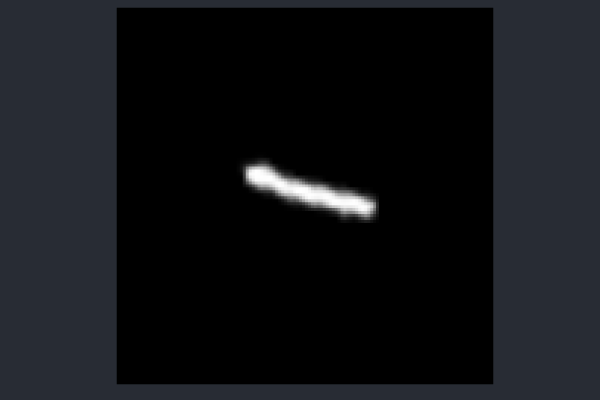

In [20]:
Plots.heatmap(
    mnist_pad(lst_train[3]),
    xlims=(1,128),
    ylims=(1,128),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:greys,
    #yflip=true,
    legend = :none,
    margin=0mm)

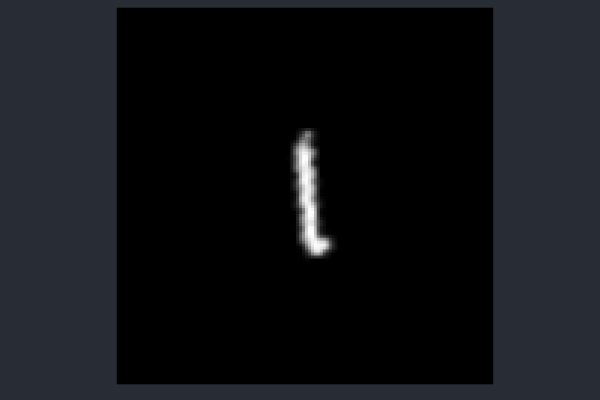

In [32]:
Plots.heatmap(
    mnist_pad(lst_test[20]),
    xlims=(1,128),
    ylims=(1,128),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:greys,
    #yflip=true,
    legend = :none,
    margin=0mm)

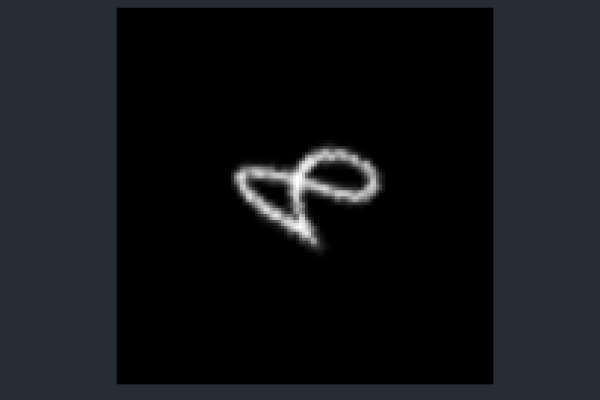

In [24]:
Plots.heatmap(
    mnist_pad(lst_valid[10]),
    xlims=(1,128),
    ylims=(1,128),
    aspectratio=1,
    axis=nothing,
    border=:none,
    c=:greys,
    #yflip=true,
    legend = :none,
    margin=0mm)

In [8]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=128,wd=2)
    
    function mnist_pad(im; θ=0.0)
        impad = zeros(Float64,64,64)
        impad[46:-1:19,19:46] = im'
        imbig = imresize(impad,(128,128))
        if θ != 0.0
            imrot = imrotate(imbig, θ, axes(imbig), Cubic(Throw(OnGrid())))
            imrot[findall(imrot .!= imrot)] .= 0.0
            return imrot
        end
        return imbig
    end
    
    function mnist_DHC(params)
        x = params
        image    = mnist_pad(x[:,:])
        WST = DHC_compute(image, filter_hash, filter_hash)
        return WST
    end
    
end
 
mnist_DHC_out = @showprogress pmap(mnist_DHC, lst_test)
mnist_DHC_out = hcat(mnist_DHC_out...)

h5write("rotmnist_DHC_test_1_1.h5", "main/data", mnist_DHC_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:41:44


In [9]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=128,wd=2)
    
    function mnist_pad(im; θ=0.0)
        impad = zeros(Float64,64,64)
        impad[46:-1:19,19:46] = im'
        imbig = imresize(impad,(128,128))
        if θ != 0.0
            imrot = imrotate(imbig, θ, axes(imbig), Cubic(Throw(OnGrid())))
            imrot[findall(imrot .!= imrot)] .= 0.0
            return imrot
        end
        return imbig
    end
    
    function mnist_DHC(params)
        x = params
        image    = mnist_pad(x[:,:])
        WST = DHC_compute(image, filter_hash, filter_hash)
        return WST
    end
    
end
 
mnist_DHC_out = @showprogress pmap(mnist_DHC, lst_train)
mnist_DHC_out = hcat(mnist_DHC_out...)

h5write("rotmnist_DHC_train_1_1.h5", "main/data", mnist_DHC_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:08:35


In [10]:
@everywhere begin
    using Statistics
    using BenchmarkTools
    using LinearAlgebra
    using Distributed
    using ProgressMeter
    push!(LOAD_PATH, pwd())
    using DHC_2DUtils
    using FFTW
    using MLDatasets
    using Images
    using Interpolations
    
    # filter bank
    filter_hash = fink_filter_hash(1,8,nx=128,wd=2)
    
    function mnist_pad(im; θ=0.0)
        impad = zeros(Float64,64,64)
        impad[46:-1:19,19:46] = im'
        imbig = imresize(impad,(128,128))
        if θ != 0.0
            imrot = imrotate(imbig, θ, axes(imbig), Cubic(Throw(OnGrid())))
            imrot[findall(imrot .!= imrot)] .= 0.0
            return imrot
        end
        return imbig
    end
    
    function mnist_DHC(params)
        x = params
        image    = mnist_pad(x[:,:])
        WST = DHC_compute(image, filter_hash, filter_hash)
        return WST
    end
    
end
 
mnist_DHC_out = @showprogress pmap(mnist_DHC, lst_valid)
mnist_DHC_out = hcat(mnist_DHC_out...)

h5write("rotmnist_DHC_valid_1_1.h5", "main/data", mnist_DHC_out)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42
